Let's start with downloading the DATA and doing some EDA.

In [69]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [70]:
import pandas as pd

# Path to the dataset file
data_path = "/root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv"

# Load the dataset
df = pd.read_csv(data_path)

# Display the first few rows
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [71]:
#Specify column names
print(df.columns)
#Drop ID column, since it's superflous, just use panda's indexing
df_new = df.drop('Unnamed: 0', axis=1)


Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


In [72]:
#Sanity check
print(df_new.head())
#"Unnamed" column is gone, as intended

                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


In [73]:
# Calculate frequency of each label in the 'label' column
label_counts = df_new['status'].value_counts()
print(label_counts)

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


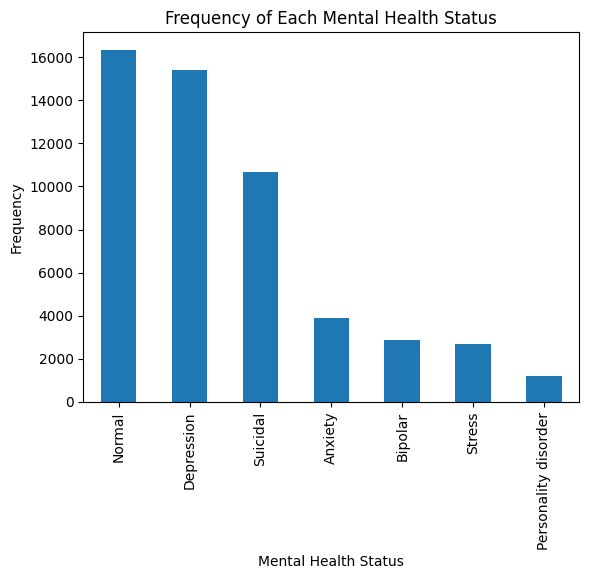

In [74]:
#Bar chart to visualize the distribution of labels
import matplotlib.pyplot as plt

df_new['status'].value_counts().plot(kind='bar')
plt.xlabel('Mental Health Status')
plt.ylabel('Frequency')
plt.title('Frequency of Each Mental Health Status')
plt.show()

Note that we have very imbalanced data, with certain classifications much less numerous than others. The "normal" classification, expectedly, is the most common one.

In [75]:
# Define a function to convert text to lowercase
def lowercase(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
    return text

# Apply this to your DataFrame column
df_new['cleaned_statement'] = df_new['statement'].apply(lowercase)

# Display the cleaned text
print(df_new[['cleaned_statement']].head())





                                   cleaned_statement
0                                         oh my gosh
1  trouble sleeping, confused mind, restless hear...
2  all wrong, back off dear, forward doubt. stay ...
3  i've shifted my focus to something else but i'...
4  i'm restless and restless, it's been a month n...


In [76]:
#Sanity check
# View original and cleaned text side-by-side
print(df_new[['statement', 'cleaned_statement']].head(10))


                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   
5  every break, you must be nervous, like somethi...   
6  I feel scared, anxious, what can I do? And may...   
7    Have you ever felt nervous but didn't know why?   
8  I haven't slept well for 2 days, it's like I'm...   
9                 I'm really worried, I want to cry.   

                                   cleaned_statement  
0                                         oh my gosh  
1  trouble sleeping, confused mind, restless hear...  
2  all wrong, back off dear, forward doubt. stay ...  
3  i've shifted my focus to something else but i'...  
4  i'm restless and restless, it's been a month n...  
5  every break, you must be nervous, like somethi... 

In [77]:
#Sanity check to make sure capital letters were removed

# Function to check for capital letters in a column
def check_capital_letters(column):
    return column.str.contains(r'[A-Z]').any()

# Check for capital letters in the "statement" column
contains_capitals = check_capital_letters(df_new['cleaned_statement'])

# Print the result of the sanity check
if not contains_capitals:
    print("Sanity check passed: No capital letters in the 'cleaned_statement' column.")
else:
    print("Sanity check failed: Capital letters found in the 'cleaned_statement' column.")



Sanity check passed: No capital letters in the 'cleaned_statement' column.


In [78]:
# Check for NaNs and empty strings
empty_entries = df_new[df_new['cleaned_statement'].isna() | (df_new['cleaned_statement'] == "")]
print("Number of empty or NaN entries:", len(empty_entries))



Number of empty or NaN entries: 362


In [79]:
# Remove rows where 'cleaned_statement' is either NaN or an empty string
df_new = df_new[df_new['cleaned_statement'].notna() & (df_new['cleaned_statement'] != "")]

In [80]:
#Sanity check--make sure NaN and empty values are removed

print("Any NaN values:", df_new['cleaned_statement'].isna().any())
print("Any empty strings:", (df_new['cleaned_statement'] == "").any())

Any NaN values: False
Any empty strings: False


Label Distribution After Cleaning:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


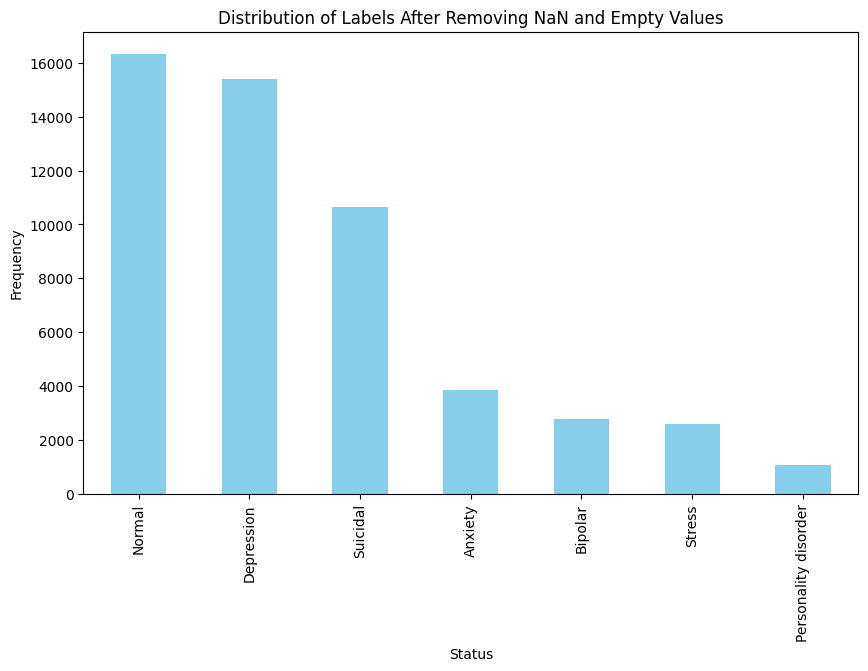

In [81]:
#Check distribution of data after NaNs and empty values removed

label_distribution = df_new['status'].value_counts()
print("Label Distribution After Cleaning:")
print(label_distribution)


# Plot label distribution
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar', color='skyblue')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.title('Distribution of Labels After Removing NaN and Empty Values')
plt.show()

Distribution looks relatively similar to original distribution after removing NaNs and empty values. This alleviates the concern that one column had a disproportionately high number of missing values.

In [82]:
#Function to remove contractions and separate into two words

import re

# Remove extra spaces around apostrophes in contractions
df_new['cleaned_statement'] = df_new['cleaned_statement'].str.replace(r"\s+([’'])\s+", r"\1", regex=True)

# Define a function to expand contractions
def expand_contractions(text):
    contractions_dict = {
        r"\bdon(?:'|’)?t\b": "do not",
        r"\bcan(?:'|’)?t\b": "cannot",
        r"\bi(?:'|’)?m\b": "i am",
        r"\byou(?:'|’)?re\b": "you are",
        r"\bthey(?:'|’)?ve\b": "they have",
        r"\bit(?:'|’)?s\b": "it is",
        r"\bis(?:'|’)?nt\b": "is not",
        r"\bwon(?:'|’)?t\b": "will not",
        r"\bdid(?:'|’)?nt\b": "did not",
        r"\bcould(?:'|’)?nt\b": "could not",
        r"\bwould(?:'|’)?nt\b": "would not",
        r"\bshould(?:'|’)?nt\b": "should not",
        r"\bdoes(?:'|’)?nt\b": "does not",
        r"\bain(?:'|’)?t\b": "is not",
        r"\bi(?:'|’)?ve\b": "i have",
        r"\bwe(?:'|’)?re\b": "we are",
        r"\bthere(?:'|’)?s\b": "there is",
        r"\bit(?:'|’)?d\b": "it would",
        r"\bwho(?:'|’)?s\b": "who is",
        r"\bwhat(?:'|’)?s\b": "what is",
        r"\bthat(?:'|’)?s\b": "that is",
        r"\blet(?:'|’)?s\b": "let us",
        r"\by(?:'|’)?all\b": "you all",
        r"\bma(?:'|’)?am\b": "madam"
    }

    # Apply each contraction replacement
    for contraction, expanded in contractions_dict.items():
        text = re.sub(contraction, expanded, text)
    return text

# Apply the contraction expansion function multiple times to catch overlaps
for _ in range(2):  # Repeat if necessary
    df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(expand_contractions)






In [83]:
#Sanity check to make sure none of the specified contractions remain

# List of contraction patterns to check for remaining occurrences
remaining_contractions_patterns = [
    r"\bdon(?:'|’)?t\b", r"\bcan(?:'|’)?t\b", r"\bi(?:'|’)?m\b", r"\byou(?:'|’)?re\b",
    r"\bthey(?:'|’)?ve\b", r"\bit(?:'|’)?s\b", r"\bis(?:'|’)?nt\b", r"\bwon(?:'|’)?t\b",
    r"\bdid(?:'|’)?nt\b", r"\bcould(?:'|’)?nt\b", r"\bwould(?:'|’)?nt\b", r"\bshould(?:'|’)?nt\b",
    r"\bdoes(?:'|’)?nt\b", r"\bain(?:'|’)?t\b", r"\bi(?:'|’)?ve\b", r"\bwe(?:'|’)?re\b",
    r"\bthere(?:'|’)?s\b", r"\bit(?:'|’)?d\b", r"\bwho(?:'|’)?s\b", r"\bwhat(?:'|’)?s\b",
    r"\bthat(?:'|’)?s\b", r"\blet(?:'|’)?s\b", r"\by(?:'|’)?all\b", r"\bma(?:'|’)?am\b"
]

# Check for each contraction and count occurrences
for pattern in remaining_contractions_patterns:
    count = df_new['cleaned_statement'].str.contains(pattern, regex=True).sum()
    print(f"Contraction pattern '{pattern}': {count} occurrences remaining")


Contraction pattern '\bdon(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bcan(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bi(?:'|’)?m\b': 0 occurrences remaining
Contraction pattern '\byou(?:'|’)?re\b': 0 occurrences remaining
Contraction pattern '\bthey(?:'|’)?ve\b': 0 occurrences remaining
Contraction pattern '\bit(?:'|’)?s\b': 0 occurrences remaining
Contraction pattern '\bis(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bwon(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bdid(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bcould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bwould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bshould(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bdoes(?:'|’)?nt\b': 0 occurrences remaining
Contraction pattern '\bain(?:'|’)?t\b': 0 occurrences remaining
Contraction pattern '\bi(?:'|’)?ve\b': 0 occurrences remaining
Contraction pattern '\bwe(?:

In [84]:
#Sanity check to check for presence of expanded form

# Dictionary of expected expansions
expected_expansions = {
    "do not": "do not",
    "cannot": "cannot",
    "i am": "i am",
    "you are": "you are",
    "they have": "they have",
    "it is": "it is",
    "is not": "is not",
    "will not": "will not",
    "did not": "did not",
    "could not": "could not",
    "would not": "would not",
    "should not": "should not",
    "does not": "does not",
    "is not": "is not",
    "i have": "i have",
    "we are": "we are",
    "there is": "there is",
    "it would": "it would",
    "who is": "who is",
    "what is": "what is",
    "that is": "that is",
    "let us": "let us",
    "you all": "you all",
    "madam": "madam"
}

# Check for presence of expanded forms
for expanded in expected_expansions.values():
    has_expansion = df_new['cleaned_statement'].str.contains(expanded, case=False).any()
    print(f"Expanded form '{expanded}' found? {has_expansion}")


Expanded form 'do not' found? True
Expanded form 'cannot' found? True
Expanded form 'i am' found? True
Expanded form 'you are' found? True
Expanded form 'they have' found? True
Expanded form 'it is' found? True
Expanded form 'is not' found? True
Expanded form 'will not' found? True
Expanded form 'did not' found? True
Expanded form 'could not' found? True
Expanded form 'would not' found? True
Expanded form 'should not' found? True
Expanded form 'does not' found? True
Expanded form 'i have' found? True
Expanded form 'we are' found? True
Expanded form 'there is' found? True
Expanded form 'it would' found? True
Expanded form 'who is' found? True
Expanded form 'what is' found? True
Expanded form 'that is' found? True
Expanded form 'let us' found? True
Expanded form 'you all' found? True
Expanded form 'madam' found? True


In [85]:
#Split data into training, validation, and test sets, converting to arrays

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert the DataFrame to a NumPy array
mh_array = df.to_numpy()   #<---- why are we using df for numpy conversion when all the ETL was done on df_new?

# Grab text and labels only
X = mh_array[:, 1] #text
y = mh_array[:, 2] #labels

# Encode labels as integers for Tensorflow
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train, val and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [86]:
# Check lengths of each dataset
print(f"Length of Training set (X_train, y_train): {len(X_train)} samples, {len(y_train)} labels")
print(f"Length of Validation set (X_val, y_val): {len(X_val)} samples, {len(y_val)} labels")
print(f"Length of Test set (X_test, y_test): {len(X_test)} samples, {len(y_test)} labels")


Length of Training set (X_train, y_train): 31825 samples, 31825 labels
Length of Validation set (X_val, y_val): 10609 samples, 10609 labels
Length of Test set (X_test, y_test): 10609 samples, 10609 labels


In [87]:
#View encoding for each label
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

print("Label encoding mapping:")
for label, number in label_mapping.items():
    print(f"'{label}' -> {number}")


Label encoding mapping:
'Anxiety' -> 0
'Bipolar' -> 1
'Depression' -> 2
'Normal' -> 3
'Personality disorder' -> 4
'Stress' -> 5
'Suicidal' -> 6


In [88]:
#Check text lengths only in training dataset (so as to not learn anything about validation and test datasets at this point)

import seaborn as sns
# Ensure all entries in X_train are strings
X_train = [str(text) if not isinstance(text, str) else text for text in X_train]

# Check lengths of text in the training dataset
text_lengths = [len(text) for text in X_train]

# Display basic statistics about text lengths
print(f"Number of training samples: {len(text_lengths)}")
print(f"Minimum text length: {min(text_lengths)} characters")
print(f"Maximum text length: {max(text_lengths)} characters")
print(f"Average text length: {sum(text_lengths) / len(text_lengths):.2f} characters")

# Optionally, display the first 5 text lengths for verification
print("\nFirst 5 text lengths:")
print(text_lengths[:5])



Number of training samples: 31825
Minimum text length: 2 characters
Maximum text length: 27390 characters
Average text length: 576.86 characters

First 5 text lengths:
[312, 745, 285, 31, 1200]


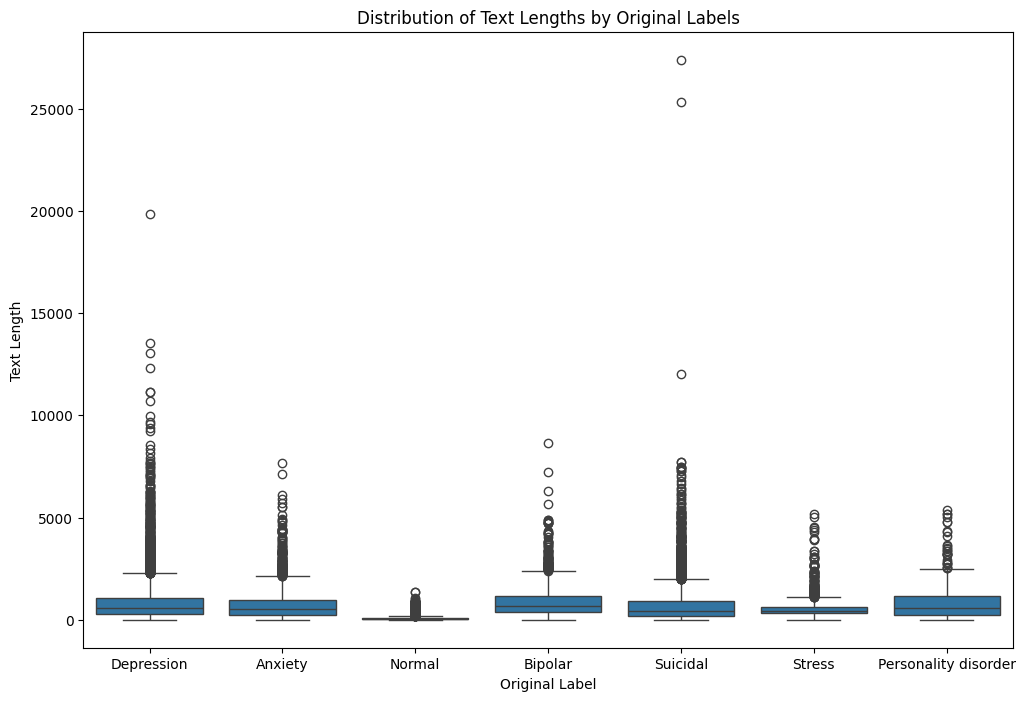

In [89]:
#Visual depiction of distribution of text lengths in X_train

import seaborn as sns

# Decode the encoded labels to their original form
original_labels = label_encoder.inverse_transform(y_train)

# Combine X_train, original labels, and text lengths into a DataFrame
train_df = pd.DataFrame({
    'text': X_train,
    'label': original_labels,  # Use original (non-encoded) labels
    'text_length': text_lengths
})

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title('Distribution of Text Lengths by Original Labels')
plt.xlabel('Original Label')
plt.ylabel('Text Length')
plt.show()


As we can see, text entries labeled "normal" are much shorter than other entries. Also, it is interesting to see the outliers of each label. Shows that a lot of statements are short in nature, but we have a significant amount for each label in Quartile 4 that have a very high text length.

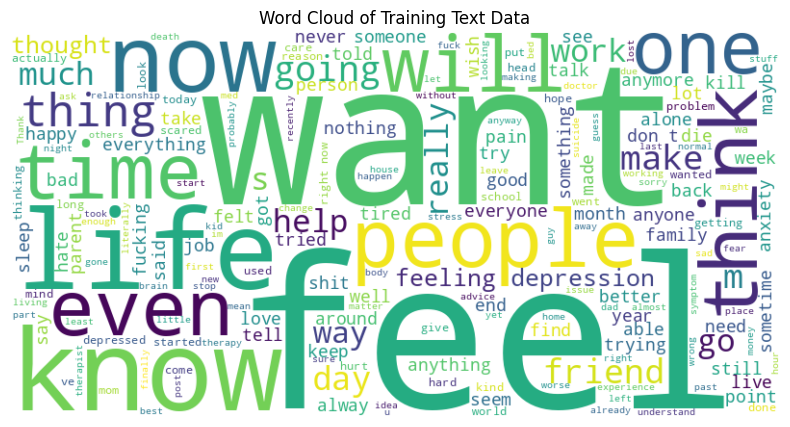

In [90]:
#Word Cloud to show commonly occuring words in X_train only

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all text data from X_train
text_data = ' '.join(str(text) for text in X_train)  # Handle X_train as a list

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Training Text Data')
plt.show()


In [91]:
duplicate_statements = df_new[df_new['statement'].duplicated(keep=False)]['statement'].unique()

# Create a dictionary to store the results
duplicate_status_comparison = {}

# Iterate through duplicate statements
for statement in duplicate_statements:
  # Get all rows with the current duplicate statement
  rows_with_statement = df_new[df_new['statement'] == statement]

  # Check if 'status' values are different
  different_status = rows_with_statement['status'].nunique() > 1

  # Store the result in the dictionary
  duplicate_status_comparison[statement] = different_status
#Create mask to identify duplicate statements with different labels
mask = df_new['statement'].isin([statement for statement, has_different_status in duplicate_status_comparison.items() if has_different_status])

# Remove rows based on the mask
df_cleaned = df_new[~mask]

# Verify the changes
duplicate_statements_cleaned = df_cleaned[df_cleaned['statement'].duplicated(keep=False)]['statement'].unique()

duplicate_status_comparison_cleaned = {}

for statement in duplicate_statements_cleaned:
  rows_with_statement = df_cleaned[df_cleaned['statement'] == statement]
  different_status = rows_with_statement['status'].nunique() > 1
  duplicate_status_comparison_cleaned[statement] = different_status

false_count = sum(value == False for value in duplicate_status_comparison_cleaned.values())
true_count = sum(value == True for value in duplicate_status_comparison_cleaned.values())

print(f"Different Status: False Count: {false_count}")
print(f"Different Status: True Count: {true_count}")  #should be 0

Different Status: False Count: 1385
Different Status: True Count: 0


In [92]:
import re
import itertools
def find_special_characters(text):
  """
  Finds and returns special characters in a string.

  Args:
    text: The input string.

  Returns:
    A list of special characters found in the string.
  """
  special_characters = re.findall(r"[^a-zA-Z0-9\s]", text)
  return special_characters

special_chars = (df_new['statement']).apply(find_special_characters)
all_special_chars = list(itertools.chain.from_iterable(special_chars))
unique_special_chars = list(set(all_special_chars))
print("Special characters:", unique_special_chars)

Special characters: ['🏴', '\\', '🤫', '°', '😒', '¼', 'ợ', '·', '𝗽', '\U0001fae3', 'ç', '⚠', '±', 'ã', 'ö', 'µ', '💸', '\x96', '💋', '‰', '️', 'ư', '❌', '😦', 'ả', '\x91', '!', 'é', '€', '⁉', '—', '♂', '🤣', '¨', '˜', '\ufeff', '¬', '💛', 'Ì', '\x8e', '½', '™', '𝗧', '🙏', '⚡', '🌊', '😹', '🤔', '⛽', '’', 'ę', '😣', '🙃', '💨', 'Ÿ', '♥', 'œ', '£', '🌷', '💅', '😐', '🍃', 'à', '¯', '𝗱', 'Ù', '³', '💕', '😵', '\U0001f979', '>', '😞', '🖕', '✨', '👩', '😜', 'í', '💩', '¾', '💝', '𝗠', '.', '\u200d', 'ữ', '\U0001fae0', '😚', '𝗴', ';', '\x84', '🙁', '😍', 'ツ', '🤍', '\x8c', '\x8d', '😬', '✌', '♀', '\x95', '‐', 'ä', '*', '🔃', '+', '|', 'Â', '›', '💔', '}', '🙂', '\x9c', '😢', '💖', '^', 'â', '😱', '😪', '𝘅', ':', '》', '𝗶', '†', '😌', '\x97', ']', 'đ', 'ỳ', '\x8f', '𝗯', '𝗘', '💀', '\x80', '÷', '🤕', '💗', '🙌', '„', '-', '➲', '😕', '🧡', '😭', '🙄', 'ì', '{', '🥰', 'ž', '🥲', 'Ã', '👍', '→', '☠', '$', 'Ï', '\U0001faf6', '[', '😨', '…', '🖤', '§', '𝗲', '𝗿', '☹', 'ê', '😆', '\x94', '🐕', '👋', '🥺', '\u200b', '😅', '🤭', '&', '\xad', '¤', '𝗹', 'Ê', '🚩'

In [93]:
### Convert emoticons to unicode
!pip install emoji==2.8.0
import emoji
import re

def find_emoticons(text):
    """Finds a wide range of emoticons in a string and returns them."""
    # Define regular expressions for different types of emoticons
    western_pattern = r"[:;][-~]?[)D]"  # Western-style emoticons (e.g., :), :-D)
    eastern_pattern = r"[\(（][_oO.][\)）]"  # Eastern-style emoticons (e.g., (^_^))
    other_pattern = r"[\^_][.,:;'\"`´!@#\$%^&*\(\)\[\]\{\}\-=+\\\|\?\/<>~]" # More Complex emoticons

    # Find all matches using all patterns
    all_matches = re.findall(western_pattern, text) + \
                  re.findall(eastern_pattern, text) + \
                  re.findall(other_pattern, text)

    # Return the unique matches
    return list(set(all_matches))

In [94]:
emoticon_representations = df_new['cleaned_statement'].apply(find_emoticons)
emoticons_representations = emoticon_representations[emoticon_representations.astype(bool)].tolist()
unique_emoticons_representations = list(set(item for sublist in emoticon_representations for item in sublist))


In [95]:
emoticon_dict = {
    ":)": "smiling_face",
    ":-)": "smiling_face",
    ":-(": "frowning_face",
    ":(": "frowning_face",
    ";-)": "wink",
    ";)": "wink",
    ":D": "grinning_face",
    ":-D": "grinning_face",
    ":P": "face_with_stuck-out_tounge",
    ":'(": "crying_face",
    ":'-(": "crying_face",
    # Add more emoticons and their text descriptions as needed
}
def replace_emoticons_with_text(text):
    """Replaces emoticons in a string with their text descriptions."""
    for emoticon, text_rep in emoticon_dict.items():
        text = text.replace(emoticon, text_rep)
    return text

In [96]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(replace_emoticons_with_text)


In [97]:
!pip install emoji==2.8.0

In [98]:
import emoji

def convert_emojis_to_unicode(text):
    """Converts emojis in a string to their Unicode representation."""
    return emoji.demojize(text)

In [99]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(convert_emojis_to_unicode)
#this converts emojis to unicode representation.. such as :smiling_face_with_smiling_eyes:

In [100]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs? going friday and need help hi i a...  


In [101]:
def find_emoji_representations(text):
    """Finds emoji representations in a string and returns them."""
    # Define a regular expression pattern to match emoji representations
    pattern = r":[\w_]+:"  # Matches :xxx: format

    # Find all matches in the text
    emoji_matches = re.findall(pattern, text)

    # Return the emoji matches
    return emoji_matches

# Apply the function to the 'cleaned_statement' column
emoji_representations = df_new['cleaned_statement'].apply(find_emoji_representations)

# Filter out empty lists (statements without emoji representations)
emoji_representations = emoji_representations[emoji_representations.astype(bool)].tolist()

# Flatten the list of lists and get unique emoji representations
unique_emoji_representations = list(set(item for sublist in emoji_representations for item in sublist))

# Print some examples of emoji representations
print("Examples of emoji representations:")
for emoji_rep in unique_emoji_representations[:10]:  # Print up to 10 examples
    print(emoji_rep)

Examples of emoji representations:
:smirking_face:
:middle_finger:
:water_wave:
:grimacing_face:
:woman_facepalming:
:unamused_face:
:carrot:
:smiling_face_with_hearts:
:face_with_peeking_eye:
:flushed_face:


In [102]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs? going friday and need help hi i a...  


In [103]:
special_chars = (df_new['cleaned_statement']).apply(find_special_characters)
all_special_chars = list(itertools.chain.from_iterable(special_chars))
unique_special_chars = list(set(all_special_chars))
print("Special characters:", unique_special_chars)

Special characters: ['ữ', '[', '…', '§', '\\', '𝗲', '𝗿', '`', '”', '𝗴', 'ê', ';', '\x83', 'ı', '°', '\x94', '\x84', '\u200b', 'ツ', '\u2060', '¼', '%', '&', '\xad', '¤', '¥', '¿', '\x8c', '\x81', '𝗹', 'ợ', 'ó', '\x99', '·', "'", '\x8d', '\x90', '‘', '𝗽', 'ç', '↑', '\x95', '±', 'ð', '#', '‐', 'ã', 'ö', 'µ', '?', '~', 'ª', '@', '"', 'ä', '\x87', '\x96', '=', '*', '𝗻', '+', '<', '\x98', '|', '‰', '¸', 'ï', '›', 'ʻ', '\x82', '\x9f', 'ư', '}', 'ả', '¢', '\x91', '–', '!', '\x9c', 'é', '(', 'š', '𝘂', '\u202c', '^', 'â', '€', '«', '—', '𝘀', 'ƒ', '¨', '»', '𝘅', '˜', ':', '\ufeff', '》', '𝘁', '¬', 'ù', '𝗶', '²', '†', '¶', '●', '\x97', 'ể', '\x8e', '½', '𝟭', '×', '𝗧', ']', '𝗼', '\x92', '•', 'đ', '\x8b', '’', 'ỳ', 'á', 'ę', 'α', 'ú', 'º', '\x88', '\x8f', '𝗯', '𝗘', '¦', '_', 'ÿ', 'ấ', '\x80', '÷', 'å', '\x8a', '/', 'œ', '\x9d', '£', '𝗰', '‚', '‡', '\x9a', 'à', '\u202d', '‹', '¯', '𝗱', '„', '³', '-', 'ë', '➲', '𝗮', 'ủ', '>', ',', 'ì', '𝗛', ')', '\u200e', '{', 'í', 'æ', '\x89', 'ž', '¡', '¾', '¹', '→',

In [104]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs? going friday and need help hi i a...  


In [105]:
def remove_special_characters_except_emojis(text, emoji_representations):
    """Removes special characters except for those in emoji_representations."""

    # Create a regex pattern to match emoji representations
    emoji_pattern = "|".join(re.escape(emoji) for emoji in emoji_representations)

    # Create a regex pattern to match special characters excluding those in emoji representations
    special_chars_pattern = r"[^a-zA-Z0-9\s" + emoji_pattern + r"]"

    # Remove special characters using the pattern
    cleaned_text = re.sub(special_chars_pattern, "", text)

    return cleaned_text

In [106]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(
    remove_special_characters_except_emojis, args=(unique_emoji_representations,)
)

In [107]:
#final sanity check
special_chars = (df_new['cleaned_statement']).apply(find_special_characters)
all_special_chars = list(itertools.chain.from_iterable(special_chars))
unique_special_chars = list(set(all_special_chars))
print("Special characters:", unique_special_chars)
#colons are within emoji representations, as are underscores
#let's remove | next

Special characters: ['_', '|', ':']


In [108]:
#Sanity check to show that emojis strings are still preserved
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs going friday and need help hi i am...  


In [109]:
df_new['cleaned_statement'] = df_new['cleaned_statement'].str.replace("|", "")
df_new['cleaned_statement'] = df_new['cleaned_statement'].str.replace(":", "")
#this removes : from emoji representations and line escapes. we keep _ for emoji representations

In [110]:
smirking_face_statements = df_new[df_new['cleaned_statement'].str.contains("crossed_fingers")]
print(smirking_face_statements)
#looking good. Can delete in final code

                                               statement   status  \
52618  C2E2 Frengs? Going friday and need help Hi I'm...  Anxiety   

                                       cleaned_statement  
52618  c2e2 frengs going friday and need help hi i am...  


In [111]:
#Remove colons from unique_emoji_representations to make it easier for Michael to exclude these from lemmatization
unique_emoji_representations = [emoji.replace(":", "") for emoji in unique_emoji_representations]
unique_emoji_representations

['smirking_face',
 'middle_finger',
 'water_wave',
 'grimacing_face',
 'woman_facepalming',
 'unamused_face',
 'carrot',
 'smiling_face_with_hearts',
 'face_with_peeking_eye',
 'flushed_face',
 'waving_hand_light_skin_tone',
 'frowning_face',
 'triangular_flag',
 'hourglass_not_done',
 'exclamation_question_mark',
 'yawning_face',
 '01am',
 'face_exhaling',
 'victory_hand',
 'fire',
 'heart_with_ribbon',
 'grinning_squinting_face',
 'downcast_face_with_sweat',
 'leaf_fluttering_in_wind',
 'red_question_mark',
 'smiling_face',
 'man_facepalming_light_skin_tone',
 'smiling_face_with_halo',
 'dr',
 'neutral_face',
 'pleading_face',
 'red_heart',
 'tulip',
 'person_shrugging',
 'smiling_face_with_smiling_eyes',
 'heart_suit',
 'skull_and_crossbones',
 'cat_with_tears_of_joy',
 'victory_hand_light_skin_tone',
 'copyright',
 'man_shrugging',
 'black_heart',
 'right_arrow',
 'frowning_face_with_open_mouth',
 'person_shrugging_medium_skin_tone',
 'kissing_face_with_closed_eyes',
 'face_with_ha

### Stopword Removal

In [112]:
#remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return " ".join(filtered_words)

df_new['cleaned_statement'] = df_new['cleaned_statement'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatization process:

Run the lemmatization on nouns, verbs and adjectives. There are unavoidable words that may not be lemmatized due to the complexities of the English language such as homographs.

Ex. the word 'felt' can be the past tense of 'feel' or the fabric 'felt'. Because of this, the lemmatizer leaves the word as 'felt'

In [113]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [114]:
# Define function for lemmatization and do it for each part of speech
def lemmatize_text(text):
    if isinstance(text, str):
        # Split text into individual words
        words = text.split()
        lemmatized_words = []
        for word in words:
            # Check if the word is in unique_emoji_representation list and skip if true
            if word in unique_emoji_representations:
                lemmatized_words.append(word)
            else:
                # Apply lemmatization for nouns, verbs, and adjectives
                word = lemmatizer.lemmatize(word, pos="n")  # nouns
                word = lemmatizer.lemmatize(word, pos="v")  # verbs
                word = lemmatizer.lemmatize(word, pos="a")  # adjectives
                lemmatized_words.append(word)
        # Rejoin lemmatized words into a single string
        return " ".join(lemmatized_words)
    return text

In [115]:
# Apply the lemmatization function
df_new['lemmatized_statement'] = df_new['cleaned_statement'].apply(lemmatize_text)

# Compare cleaned and lemmatized statements
comparison = df_new[['cleaned_statement', 'lemmatized_statement']].head(10)
print(comparison)

                                   cleaned_statement  \
0                                            oh gosh   
1  trouble sleeping confused mind restless heart ...   
2  wrong back dear forward doubt stay restless re...   
3         shifted focus something else still worried   
4                   restless restless month boy mean   
5  every break must nervous like something wrong ...   
6  feel scared anxious may family us protected sm...   
7                       ever felt nervous didnt know   
8  havent slept well 2 days like restless huh fro...   
9                            really worried want cry   

                                lemmatized_statement  
0                                            oh gosh  
1     trouble sleep confuse mind restless heart tune  
2  wrong back dear forward doubt stay restless re...  
3             shift focus something else still worry  
4                   restless restless month boy mean  
5  every break must nervous like something wrong ... 

Now that the text preprocessing is done, we'll split the dataset into training, validation, and do some more EDA.

In [116]:
#Split data into training, validation, and test sets, converting to arrays

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert the DataFrame to a NumPy array
mh_array = df_new.to_numpy()

# Grab text and labels only
X = mh_array[:, 3] #lemmatized text
y = mh_array[:, 1] #labels

# Encode labels as integers for Tensorflow
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train, val and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [117]:
# Check lengths of each dataset
print(f"Length of Training set (X_train, y_train): {len(X_train)} samples, {len(y_train)} labels")
print(f"Length of Validation set (X_val, y_val): {len(X_val)} samples, {len(y_val)} labels")
print(f"Length of Test set (X_test, y_test): {len(X_test)} samples, {len(y_test)} labels")

Length of Training set (X_train, y_train): 31608 samples, 31608 labels
Length of Validation set (X_val, y_val): 10536 samples, 10536 labels
Length of Test set (X_test, y_test): 10537 samples, 10537 labels


In [118]:
#View encoding for each label
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

print("Label encoding mapping:")
for label, number in label_mapping.items():
    print(f"'{label}' -> {number}")

Label encoding mapping:
'Anxiety' -> 0
'Bipolar' -> 1
'Depression' -> 2
'Normal' -> 3
'Personality disorder' -> 4
'Stress' -> 5
'Suicidal' -> 6


In [119]:
#Check text lengths only in training dataset (so as to not learn anything about validation and test datasets at this point)

# Ensure all entries in X_train are strings
X_train = [str(text) if not isinstance(text, str) else text for text in X_train]

# Check lengths of text in the training dataset
text_lengths = [len(text) for text in X_train]

# Display basic statistics about text lengths
print(f"Number of training samples: {len(text_lengths)}")
print(f"Minimum text length: {min(text_lengths)} characters")
print(f"Maximum text length: {max(text_lengths)} characters")
print(f"Average text length: {sum(text_lengths) / len(text_lengths):.2f} characters")

# Optionally, display the first 5 text lengths for verification
print("\nFirst 5 text lengths:")
print(text_lengths[:5])

Number of training samples: 31608
Minimum text length: 0 characters
Maximum text length: 25289 characters
Average text length: 322.96 characters

First 5 text lengths:
[44, 548, 189, 58, 37]


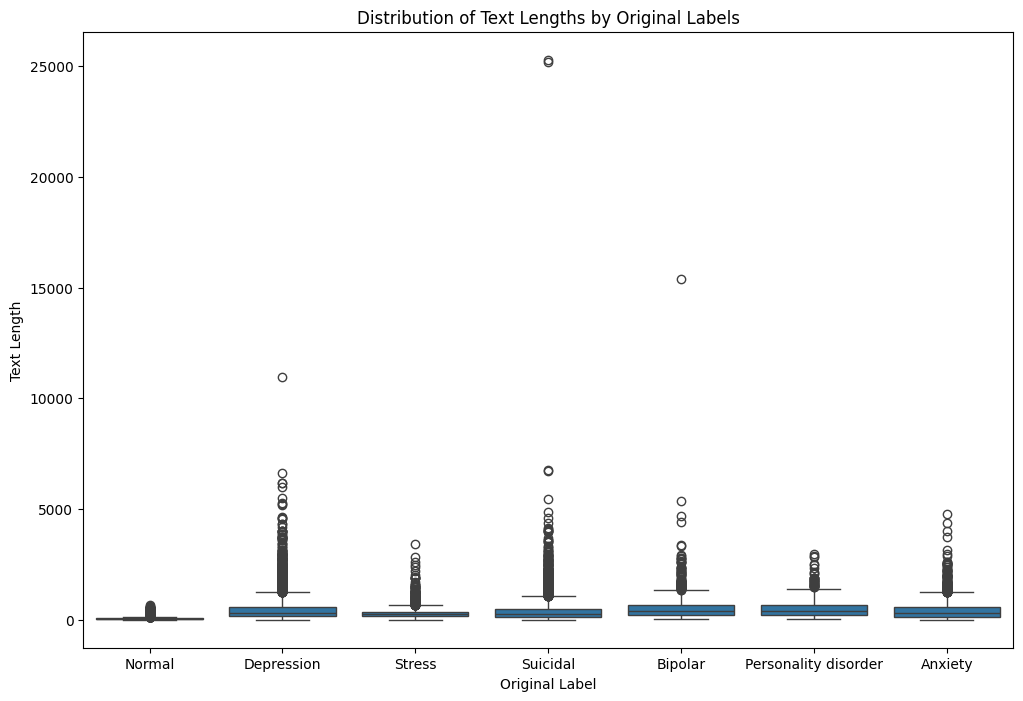

In [120]:
#Visual depiction of distribution of text lengths in X_train

import seaborn as sns
import matplotlib.pyplot as plt

# Decode the encoded labels to their original form
original_labels = label_encoder.inverse_transform(y_train)

# Combine X_train, original labels, and text lengths into a DataFrame
train_df = pd.DataFrame({
    'text': X_train,
    'label': original_labels,  # Use original (non-encoded) labels
    'text_length': text_lengths
})

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='text_length', data=train_df)
plt.title('Distribution of Text Lengths by Original Labels')
plt.xlabel('Original Label')
plt.ylabel('Text Length')
plt.show()


As we can see, text entries labeled "normal" are much shorter than other entries. Also, it is interesting to see the outliers of each label. Shows that a lot of statements are short in nature, but we have a significant amount for each label in Quartile 4 that have a very high text length.

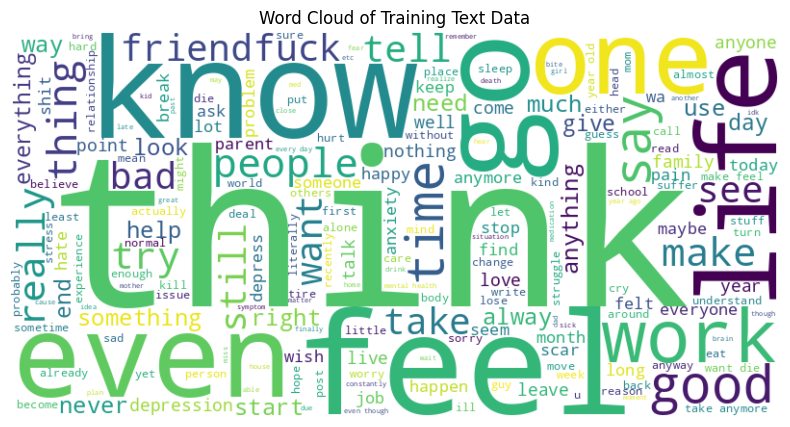

In [121]:
#Word Cloud to show commonly occuring words in X_train only

from wordcloud import WordCloud, STOPWORDS

# Combine all text data from X_train
text_data = ' '.join(str(text) for text in X_train)  # Handle X_train as a list

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Training Text Data')
plt.show()

Now, we'll convert the text into integers using a Text Vectorization layer.

In [122]:
import tensorflow as tf
from tensorflow.keras import layers

#tokenize and vectorize text
max_features = 10000
sequence_length = 500 #will pad sequences to length 500

vectorize_layer = layers.TextVectorization(max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

#adapting vectorize layer to X_train
vectorize_layer.adapt(X_train)

In [123]:
#sanity check: try vectorizing first five examples of X_train
for text in X_train[:5]:
    print(text)
    print(vectorize_layer(text))

2 night sleep really well wake late wkwkwkwk
tf.Tensor(
[ 152  109   78   17   93  162  182 7237    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 

In [124]:
#vocabulary examples
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  six
 313 --->  dead
Vocabulary size: 10000


In [125]:
#applying vectorization to train, test and val
X_train_vectorized = vectorize_layer(X_train)
X_test_vectorized = vectorize_layer(X_test)
X_val_vectorized = vectorize_layer(X_val)

#combining train, test and val into datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val))

#configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [126]:
#Prepare data for bag of words baseline model by using CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform it into a bag-of-words representation
X_train_bow = vectorizer.fit_transform(X_train)

# Transform validation and test sets using the same vectorizer
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

# Verify shapes
print("Training set shape:", X_train_bow.shape)
print("Validation set shape:", X_val_bow.shape)
print("Test set shape:", X_test_bow.shape)


Training set shape: (31608, 48655)
Validation set shape: (10536, 48655)
Test set shape: (10537, 48655)


In [127]:
#Convert labels to either 0 (normal) or 1 (abnormal) for binary model
import numpy as np

# Map the labels into two categories: 'normal' and 'abnormal'
y_train_binary = np.where(y_train == 3, 0, 1)  # 0 for 'Normal', 1 for 'Abnormal'
y_val_binary = np.where(y_val == 3, 0, 1)
y_test_binary = np.where(y_test == 3, 0, 1)

# Verify the transformation
print("Binary labels distribution:")
print(f"Training set - Normal: {np.sum(y_train_binary == 0)}, Abnormal: {np.sum(y_train_binary == 1)}")
print(f"Validation set - Normal: {np.sum(y_val_binary == 0)}, Abnormal: {np.sum(y_val_binary == 1)}")


Binary labels distribution:
Training set - Normal: 9697, Abnormal: 21911
Validation set - Normal: 3297, Abnormal: 7239


MODEL TRAINING

In [128]:
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_ds = train_ds.batch(64)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_ds = val_ds.batch(64)
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_ds = test_ds.batch(64)

BASELINE MULTICLASS MODEL

In [66]:
from tensorflow.keras import layers, losses, metrics, optimizers

# Define variables
max_features = 10000
embedding_dim = 128
num_classes = 7

# Simple baseline model
baseline_model = tf.keras.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(num_classes, activation='softmax')
])

baseline_model.summary()

# Compile the baseline model
baseline_model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer='adam',  # Use default Adam optimizer
    metrics=[metrics.SparseCategoricalAccuracy()]
)

# Train the baseline model
baseline_epochs = 25
baseline_history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=baseline_epochs
)

# Evaluate the baseline model
baseline_loss, baseline_accuracy = baseline_model.evaluate(test_ds)

print("Baseline Loss: ", baseline_loss)
print("Baseline Accuracy: ", baseline_accuracy)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 1.5806 - sparse_categorical_accuracy: 0.3802 - val_loss: 1.4102 - val_sparse_categorical_accuracy: 0.5297
Epoch 2/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.3671 - sparse_categorical_accuracy: 0.4994 - val_loss: 1.2752 - val_sparse_categorical_accuracy: 0.5425
Epoch 3/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.2376 - sparse_categorical_accuracy: 0.5402 - val_loss: 1.1647 - val_sparse_categorical_accuracy: 0.5652
Epoch 4/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1377 - sparse_categorical_accuracy: 0.5815 - val_loss: 1.0861 - val_sparse_categorical_accuracy: 0.6169
Epoch 5/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0627 - sparse_categorical_accuracy: 0.6122 - val_loss: 1.0274 - val_sparse_categorical_accuracy: 0.6334
Epoch 6/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0043 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.9821 - val_sparse_categorical_accuracy: 0.6417
Epo

In [132]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


IMPROVED MULTICLASS MODEL

In [ ]:
import keras_tuner
from tensorflow.keras import layers, losses, metrics

def build_model(hp):
    model = tf.keras.Sequential([
        # Embedding layer
        layers.Embedding(
            input_dim=max_features,
            output_dim=hp.Choice('embedding_dim', [64, 128])  # Test larger embedding dimensions
        ),
        layers.Dropout(hp.Float('embedding_dropout', min_value=0.1, max_value=0.5, step=0.1)),  # Tune dropout

        # Bidirectional LSTM
        layers.Bidirectional(layers.LSTM(
            units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),  # Tune LSTM units
            return_sequences=False
        )),

        # Dense layers
        layers.Dense(
            units=hp.Int('dense1_units', min_value=64, max_value=256, step=64),  # Tune dense units
            activation='relu'
        ),
        layers.Dropout(hp.Float('dense1_dropout', min_value=0.2, max_value=0.5, step=0.1)),  # Tune dropout rate

        layers.Dense(
            units=hp.Int('dense2_units', min_value=64, max_value=256, step=64),  # Tune dense units
            activation='relu'
        ),
        layers.Dropout(hp.Float('dense2_dropout', min_value=0.2, max_value=0.5, step=0.1)),  # Tune dropout rate

        # Output layer
        layers.Dense(num_classes, activation='softmax')  # Multiclass classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])  # Tune learning rate
        ),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='val_sparse_categorical_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='enhanced_tuner_dir',
    project_name='enhanced_text_classification'
)

# Use tuner
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Allow for longer training if necessary
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Grab best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best embedding_dim: {best_hps.get('embedding_dim')}")
print(f"Best lstm_units: {best_hps.get('lstm_units')}")
print(f"Best dense1_units: {best_hps.get('dense1_units')}")
print(f"Best dense2_units: {best_hps.get('dense2_units')}")
print(f"Best embedding_dropout: {best_hps.get('embedding_dropout')}")
print(f"Best dense1_dropout: {best_hps.get('dense1_dropout')}")
print(f"Best dense2_dropout: {best_hps.get('dense2_dropout')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Run on test data
loss, accuracy = best_model.evaluate(test_ds)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)


Trial 15 Complete [00h 11m 33s]
val_sparse_categorical_accuracy: 0.7189635634422302

Best val_sparse_categorical_accuracy So Far: 0.7491458058357239
Total elapsed time: 01h 44m 20s
Best embedding_dim: 128
Best lstm_units: 192
Best dense1_units: 256
Best dense2_units: 192
Best embedding_dropout: 0.5
Best dense1_dropout: 0.2
Best dense2_dropout: 0.30000000000000004
Best learning_rate: 0.001
Epoch 1/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - loss: 1.2455 - sparse_categorical_accuracy: 0.5282 - val_loss: 0.8417 - val_sparse_categorical_accuracy: 0.6838
Epoch 2/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 0.7997 - sparse_categorical_accuracy: 0.6994 - val_loss: 0.7251 - val_sparse_categorical_accuracy: 0.7304
Epoch 3/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.7341
Epoch 4/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - loss: 0.5567 - sparse_categorical_accuracy: 0.79

BEST MULTICLASS MODEL BROKEN OUT

In [67]:
from tensorflow.keras import layers, losses, metrics, optimizers
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Hyperparameters
embedding_dim = 128
lstm_units = 192
dense1_units = 256
dense2_units = 192
embedding_dropout = 0.5
dense1_dropout = 0.2
dense2_dropout = 0.3
learning_rate = 0.001
num_classes = 7

# Build model
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(embedding_dropout),
    layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False)),
    layers.Dropout(dense1_dropout),
    layers.Dense(dense1_units, activation='relu'),
    layers.Dropout(dense2_dropout),
    layers.Dense(dense2_units, activation='relu'),
    layers.Dropout(dense2_dropout),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Compile model
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=[metrics.SparseCategoricalAccuracy()]
)

# Assign class weights
y_train = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to class weights to dictionary
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

# Train model
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    class_weight=class_weights,  # Add class weights
    epochs=epochs
)

# Evaluate model
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Computed class weights: {0: 1.930495327673609, 1: 2.6781901372648704, 2: 0.48746934809765424, 3: 0.46565211626570807, 4: 6.957517059211974, 5: 2.8596761060345606, 6: 0.7060873450240143}
Epoch 1/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 1.6684 - sparse_categorical_accuracy: 0.3953 - val_loss: 0.9810 - val_sparse_categorical_accuracy: 0.6111
Epoch 2/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - loss: 1.0380 - sparse_categorical_accuracy: 0.5932 - val_loss: 1.0220 - val_sparse_categorical_accuracy: 0.6140
Epoch 3/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - loss: 0.8027 - sparse_categorical_accuracy: 0.6578 - val_loss: 0.8665 - val_sparse_categorical_accuracy: 0.6765
Epoch 4/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.6710 - sparse_categorical_accuracy: 0.7065 - val_loss: 0.8385 - val_sparse_categorical_accuracy: 0.6936
Epoch 5/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 0.5910 - sparse_categorical_accuracy: 0.7338 - val_loss: 0.8144 - val_sparse_cat

In [69]:
from sklearn.metrics import f1_score

"IMPROVED" MULTICLASS F1 SCORE

In [72]:
# Grab predictions from test
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("Updated Model F1 Score:", f1)


165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step
Updated Model F1 Score: 0.7301537036800234


BASELINE MULTICLASS F1 SCORE

In [71]:
# Get predictions from the baseline model
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # True labels
y_pred_probs = baseline_model.predict(test_ds)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multiclass
print("Baseline Model F1 Score:", f1)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Baseline Model F1 Score: 0.7434142507212337


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       776
           1       0.77      0.74      0.75       537
           2       0.69      0.62      0.66      3043
           3       0.92      0.88      0.90      3349
           4       0.52      0.56      0.54       200
           5       0.46      0.57      0.51       464
           6       0.58      0.66      0.62      2168

    accuracy                           0.73     10537
   macro avg       0.67      0.69      0.68     10537
weighted avg       0.74      0.73      0.73     10537



BINARY MODEL

In [66]:
#combining binary train, test and val into datasets
train_ds_binary = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_binary))
test_ds_binary = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test_binary))
val_ds_binary = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val_binary))

#configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds_binary = train_ds_binary.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_binary = val_ds_binary.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_binary = test_ds_binary.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_binary = train_ds_binary.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_ds_binary = train_ds_binary.batch(64)
val_ds_binary = val_ds_binary.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_ds_binary = val_ds_binary.batch(64)
test_ds_binary = test_ds_binary.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_ds_binary = test_ds_binary.batch(64)

BASELINE BINARY

In [75]:
from tensorflow.keras import layers, losses, metrics, optimizers

# Simple baseline model
baseline_model = tf.keras.Sequential([
    layers.Dense(1, activation='sigmoid')
])

# Compile the baseline model
baseline_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer='adam',
    metrics=[metrics.BinaryAccuracy(threshold=0.5)]
)

# Train the baseline model
baseline_epochs = 20
baseline_history = baseline_model.fit(
    train_ds_binary,
    validation_data=val_ds_binary,
    epochs=baseline_epochs
)

# Evaluate the baseline model
baseline_loss, baseline_accuracy = baseline_model.evaluate(test_ds_binary)

print("Baseline Model Loss: ", baseline_loss)
print("Baseline Model Accuracy: ", baseline_accuracy)


Epoch 1/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.7340 - loss: 42.2691 - val_binary_accuracy: 0.7509 - val_loss: 2.8276
Epoch 2/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.7665 - loss: 2.5598 - val_binary_accuracy: 0.7793 - val_loss: 1.8601
Epoch 3/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.7731 - loss: 1.7275 - val_binary_accuracy: 0.7772 - val_loss: 1.7257
Epoch 4/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.7715 - loss: 1.5660 - val_binary_accuracy: 0.7903 - val_loss: 1.3599
Epoch 5/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.7707 - loss: 1.4627 - val_binary_accuracy: 0.7783 - val_loss: 1.4188
Epoch 6/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.7735 - loss: 1.3996 - val_binary_accuracy: 0.7730 - val_loss: 1.5383
Epoch 7/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - binary_accuracy: 0.7704 - loss: 1.5046 - val_binary_accuracy: 0.7777 - val_loss: 1.5008
Epoch

IMPROVED BINARY MODEL

In [1]:
from tensorflow.keras import layers

# Define improved model
complex_model = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile improved model
complex_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.001),  # Custom learning rate
    metrics=[metrics.BinaryAccuracy(threshold=0.5)]
)

# Train improved model
complex_epochs = 20
complex_history = complex_model.fit(
    train_ds_binary,
    validation_data=val_ds_binary,
    epochs=complex_epochs
)

# Evaluate improved model
complex_loss, complex_accuracy = complex_model.evaluate(test_ds_binary)

print("Improved Model Loss: ", complex_loss)
print("Improved Model Accuracy: ", complex_accuracy)


NameError: name 'tf' is not defined

In [79]:
import keras_tuner as kt
from tensorflow.keras import layers, optimizers, losses, metrics

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential([
        layers.Dense(
            units=hp.Int('dense1_units', min_value=64, max_value=256, step=32),
            activation='relu'
        ),
        layers.Dropout(hp.Float('dense1_dropout', min_value=0.1, max_value=0.5, step=0.1)),
        layers.Dense(
            units=hp.Int('dense2_units', min_value=32, max_value=128, step=16),
            activation='relu'
        ),
        layers.Dropout(hp.Float('dense2_dropout', min_value=0.1, max_value=0.5, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss=losses.BinaryCrossentropy(),
        metrics=[metrics.BinaryAccuracy(threshold=0.5)]
    )
    return model

# Create a Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_binary_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='binary_classification'
)

# Early Stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters
tuner.search(
    train_ds_binary,
    validation_data=val_ds_binary,
    epochs=20,
    callbacks=[stop_early]
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best dense1_units: {best_hps.get('dense1_units')}")
print(f"Best dense1_dropout: {best_hps.get('dense1_dropout')}")
print(f"Best dense2_units: {best_hps.get('dense2_units')}")
print(f"Best dense2_dropout: {best_hps.get('dense2_dropout')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")

# Build and train the model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_ds_binary,
    validation_data=val_ds_binary,
    epochs=20,
    callbacks=[stop_early]
)

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(test_ds_binary)
print("Best Model Loss: ", loss)
print("Best Model Accuracy: ", accuracy)


Trial 30 Complete [00h 01m 02s]
val_binary_accuracy: 0.8320045471191406

Best val_binary_accuracy So Far: 0.8628512024879456
Total elapsed time: 00h 13m 03s
Best dense1_units: 64
Best dense1_dropout: 0.2
Best dense2_units: 128
Best dense2_dropout: 0.2
Best learning_rate: 0.003010139030945836
Epoch 1/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.7594 - loss: 15.4386 - val_binary_accuracy: 0.8034 - val_loss: 0.6131
Epoch 2/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - binary_accuracy: 0.7832 - loss: 0.6434 - val_binary_accuracy: 0.8090 - val_loss: 0.4849
Epoch 3/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8092 - loss: 0.4809 - val_binary_accuracy: 0.8377 - val_loss: 0.4507
Epoch 4/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8292 - loss: 0.4272 - val_binary_accuracy: 0.8504 - val_loss: 0.4307
Epoch 5/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8373 - loss: 0.3999 - val_binary_accuracy: 0.8364 - val_loss: 0.3

MULTICLASS BUCKETED

In [129]:
import numpy as np

# Define mappings for the broader buckets
# 0: Normal, 1: Mood Disorders, 2: Anxiety/Stress, 3: Personality Disorders, 4: Crisis/Severe
def map_to_buckets(label):
    if label == 3:  # Normal
        return 0
    elif label in [1, 2]:  # Mood Disorders
        return 1
    elif label in [0, 5]:  # Anxiety/Stress
        return 2
    elif label == 4:  # Personality Disorders
        return 3
    elif label == 6:  # Crisis/Severe
        return 4

# Apply the mapping to create bucketed labels
y_train_buckets = np.array([map_to_buckets(label) for label in y_train])
y_val_buckets = np.array([map_to_buckets(label) for label in y_val])
y_test_buckets = np.array([map_to_buckets(label) for label in y_test])

# Verify the transformation
print("Bucketed labels distribution:")
for i in range(5):  # Buckets 0 through 4
    print(f"Training set - Bucket {i}: {np.sum(y_train_buckets == i)}")
    print(f"Validation set - Bucket {i}: {np.sum(y_val_buckets == i)}")
    print(f"Test set - Bucket {i}: {np.sum(y_test_buckets == i)}")


Bucketed labels distribution:
Training set - Bucket 0: 9697
Validation set - Bucket 0: 3297
Test set - Bucket 0: 3349
Training set - Bucket 1: 10949
Validation set - Bucket 1: 3652
Test set - Bucket 1: 3580
Training set - Bucket 2: 3918
Validation set - Bucket 2: 1270
Test set - Bucket 2: 1240
Training set - Bucket 3: 649
Validation set - Bucket 3: 228
Test set - Bucket 3: 200
Training set - Bucket 4: 6395
Validation set - Bucket 4: 2089
Test set - Bucket 4: 2168


In [130]:
#combining binary train, test and val into datasets
train_ds_buckets = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_buckets))
test_ds_buckets = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test_buckets))
val_ds_buckets = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val_buckets))

#configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds_buckets = train_ds_buckets.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_buckets = val_ds_buckets.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_buckets = test_ds_buckets.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_buckets = train_ds_buckets.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_ds_buckets = train_ds_buckets.batch(64)
val_ds_buckets = val_ds_buckets.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_ds_buckets = val_ds_buckets.batch(64)
test_ds_buckets = test_ds_buckets.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_ds_buckets = test_ds_buckets.batch(64)

In [66]:
from tensorflow.keras import layers, losses, metrics, optimizers
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers

# Hyperparameters
embedding_dim = 128
lstm_units = 192
dense1_units = 256
dense2_units = 192
embedding_dropout = 0.5
dense1_dropout = 0.2
dense2_dropout = 0.3
learning_rate = 0.001
num_classes = 7

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(embedding_dropout),
    layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False)),
    layers.Dropout(dense1_dropout),
    layers.Dense(dense1_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(dense2_dropout),
    layers.Dense(dense2_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(dense2_dropout),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Compile model
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=[metrics.SparseCategoricalAccuracy()]
)

# Assign class weights
y_train_buckets = np.concatenate([y for x, y in train_ds_buckets], axis=0)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_buckets),
    y=y_train_buckets
)

# Convert to class weights to dictionary
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

# Train model
epochs = 25
history = model.fit(
    train_ds_buckets,
    validation_data=val_ds_buckets,
    class_weight=class_weights,  # Add class weights
    epochs=epochs
)

# Evaluate model
loss, accuracy = model.evaluate(test_ds_buckets)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Computed class weights: {0: 0.6519129627719913, 1: 0.5773677961457667, 2: 1.6134762633996937, 3: 9.740523882896765, 4: 0.98852228303362}
Epoch 1/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - loss: 2.8769 - sparse_categorical_accuracy: 0.4082 - val_loss: 1.0925 - val_sparse_categorical_accuracy: 0.6050
Epoch 2/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - loss: 1.1237 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.5900
Epoch 3/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - loss: 1.0443 - sparse_categorical_accuracy: 0.5609 - val_loss: 0.9623 - val_sparse_categorical_accuracy: 0.5998
Epoch 4/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - loss: 0.9281 - sparse_categorical_accuracy: 0.6022 - val_loss: 0.8723 - val_sparse_categorical_accuracy: 0.6709
Epoch 5/25
494/494 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - loss: 0.7822 - sparse_categorical_accuracy: 0.6728 - val_loss: 0.8629 - val_sparse_categorical_accuracy: 0.6913
Epoch 6/25
494/494 ━━━━

In [133]:
from tensorflow.keras import layers, losses, metrics, optimizers
import keras_tuner
from tensorflow.keras import layers, losses, metrics

def build_model(hp):
    model = tf.keras.Sequential([
        # Embedding layer
        layers.Embedding(
            input_dim=max_features,
            output_dim=hp.Choice('embedding_dim', [64, 128])  # Test larger embedding dimensions
        ),
        layers.Dropout(hp.Float('embedding_dropout', min_value=0.1, max_value=0.5, step=0.1)),  # Tune dropout

        # Bidirectional LSTM
        layers.Bidirectional(layers.LSTM(
            units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),  # Tune LSTM units
            return_sequences=False
        )),

        # Dense layers
        layers.Dense(
            units=hp.Int('dense1_units', min_value=64, max_value=256, step=64),  # Tune dense units
            activation='relu'
        ),
        layers.Dropout(hp.Float('dense1_dropout', min_value=0.2, max_value=0.5, step=0.1)),  # Tune dropout rate

        layers.Dense(
            units=hp.Int('dense2_units', min_value=64, max_value=256, step=64),  # Tune dense units
            activation='relu'
        ),
        layers.Dropout(hp.Float('dense2_dropout', min_value=0.2, max_value=0.5, step=0.1)),  # Tune dropout rate

        # Output layer
        layers.Dense(num_classes, activation='softmax')  # Multiclass classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])  # Tune learning rate
        ),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()]
    )
    return model


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='val_sparse_categorical_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='enhanced_tuner_dir',
    project_name='enhanced_text_classification'
)

# Use tuner
tuner.search(
    train_ds_buckets,
    validation_data=val_ds_buckets,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Grab best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best embedding_dim: {best_hps.get('embedding_dim')}")
print(f"Best lstm_units: {best_hps.get('lstm_units')}")
print(f"Best dense1_units: {best_hps.get('dense1_units')}")
print(f"Best dense2_units: {best_hps.get('dense2_units')}")
print(f"Best embedding_dropout: {best_hps.get('embedding_dropout')}")
print(f"Best dense1_dropout: {best_hps.get('dense1_dropout')}")
print(f"Best dense2_dropout: {best_hps.get('dense2_dropout')}")
print(f"Best learning_rate: {best_hps.get('learning_rate')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    train_ds_buckets,
    validation_data=val_ds_buckets,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Run on test data
loss, accuracy = best_model.evaluate(test_ds_buckets)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)


Trial 7 Complete [00h 08m 05s]
val_sparse_categorical_accuracy: 0.7551252841949463

Best val_sparse_categorical_accuracy So Far: 0.7648063898086548
Total elapsed time: 00h 51m 53s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
128               |128               |embedding_dim
0.2               |0.2               |embedding_dropout
192               |64                |lstm_units
256               |256               |dense1_units
0.4               |0.3               |dense1_dropout
192               |64                |dense2_units
0.3               |0.3               |dense2_dropout
0.01              |0.001             |learning_rate

Epoch 1/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - loss: 1.1460 - sparse_categorical_accuracy: 0.5813 - val_loss: 0.6818 - val_sparse_categorical_accuracy: 0.7356
Epoch 2/30
494/494 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - loss: 0.6793 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.6843 - val_sparse_categorical_acc